In [2]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=a2f02adb0ded61ab2c7274393d37dbb653e0e78eecb44e2590b3ad1bdf3d0239
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import random
from data_rnn import load_ndfa, load_brackets

NDFA

Q6

In [7]:
x_train, (i2w, w2i) = load_ndfa(n=150_000)

In [8]:
i2w

['.pad',
 '.start',
 '.end',
 '.unk',
 'c',
 'l',
 'a',
 'b',
 'm',
 'w',
 'u',
 'v',
 '!',
 's',
 'k']

In [9]:
w2i

{'.pad': 0,
 '.start': 1,
 '.end': 2,
 '.unk': 3,
 'c': 4,
 'l': 5,
 'a': 6,
 'b': 7,
 'm': 8,
 'w': 9,
 'u': 10,
 'v': 11,
 '!': 12,
 's': 13,
 'k': 14}

In [10]:
print((x_train[149999]))
print()
print(''.join([i2w[i] for i in  x_train[149993]]) )


[13, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 6, 7, 4, 12, 13]

suvw!uvw!uvw!uvw!uvw!uvw!uvw!uvw!uvw!uvw!uvw!uvw!uvw!uvw!uvw!uvw!uvw!uvw!uvw!uvw!uvw!uvw!uvw!uvw!uvw!uvw!uvw!uvw!uvw!uvw!uvw!uvw!uvw!s


In [11]:
import numpy as np
import torch

def create_batches(data, max_tokens_per_batch):
    batches = []
    current_batch = []
    current_tokens = 0

    for sequence in data:
        if current_tokens + len(sequence) <= max_tokens_per_batch:
            current_batch.append(sequence)
            current_tokens += len(sequence)
        else:
            batches.append(current_batch)
            current_batch = [sequence]
            current_tokens = len(sequence)

    if current_batch:
        batches.append(current_batch)

    # Shuffle batches
    np.random.shuffle(batches)

    return batches

def process_batches(batch, w2i):
    processed_batch = []
    for _, sequence in enumerate(batch):
        sequence_with_start = [w2i['.start']] + batch[0]
        sequence_with_pad = sequence_with_start + [w2i['.pad']] * (max_tokens_per_batch - len(sequence_with_start))
        sequence_with_end = sequence_with_pad + [w2i['.end']]

        processed_batch.append(sequence_with_end)

    target_batches = [batch[1:] + [w2i['.end']] for batch in processed_batch]


    input_tensor = torch.tensor(processed_batch, dtype=torch.long)
    target_tensor = torch.tensor(target_batches, dtype=torch.long)

    return input_tensor, target_tensor

# Example usage
max_tokens_per_batch = 10000
batches = create_batches(x_train, max_tokens_per_batch)
print(f'Number of batches created is {len(batches)}')
print()

for i in range(5):
    input_tensor, target_tensor = process_batches(batches[i], w2i)
    print(f'The shape of batch number {i} is {input_tensor.shape}')

Number of batches created is 210

The shape of batch number 0 is torch.Size([333, 10001])
The shape of batch number 1 is torch.Size([229, 10001])
The shape of batch number 2 is torch.Size([294, 10001])
The shape of batch number 3 is torch.Size([294, 10001])
The shape of batch number 4 is torch.Size([238, 10001])


In [12]:
input_tensor.shape

torch.Size([238, 10001])

In [13]:
class LSTM(nn.Module):
    def __init__(self, input_dim, embed_size, hidden_dim, vocab, lstm_layers):
        super().__init__()
        self.embed = nn.Embedding(input_dim, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_dim, lstm_layers, batch_first=True)
        self.Linear = nn.Linear(hidden_dim, vocab)


    def forward(self, x):
        input = x
        x = self.embed(x)
        x, _ = self.lstm(x)
        x = self.Linear(x)
        return x





In [14]:
vocab = len(w2i)
embed_size = 32
hidden_dim = 16
lstm_layers = 2
model = LSTM(vocab, embed_size, hidden_dim, vocab, lstm_layers)




In [15]:
model

LSTM(
  (embed): Embedding(15, 32)
  (lstm): LSTM(32, 16, num_layers=2, batch_first=True)
  (Linear): Linear(in_features=16, out_features=15, bias=True)
)

Q7

In [16]:
import torch.distributions as dist
def sample(lnprobs, temperature=1.0):
    """
         Sample an element from a categorical distribution
         :param lnprobs: Outcome logits
         :param temperature: Sampling temperature. 1.0 follows the given
distribution, 0.0 returns the maximum probability element. :return: The index of the sampled element.
"""
    if temperature == 0.0:
        return lnprobs.argmax()
    p = F.softmax(lnprobs / temperature, dim=0)
    cd = dist.Categorical(p)
    return cd.sample()


In [17]:
print(w2i)

{'.pad': 0, '.start': 1, '.end': 2, '.unk': 3, 'c': 4, 'l': 5, 'a': 6, 'b': 7, 'm': 8, 'w': 9, 'u': 10, 'v': 11, '!': 12, 's': 13, 'k': 14}


In [18]:
#make a seed sequence
seq = [w2i['.start'], w2i['a'], w2i['b'], w2i['b'], w2i['a'], w2i['.end']]
#transform the sequence into a tensor and add a singleton dimension
seq = torch.tensor(seq).unsqueeze(0)
#feed the sequence to the model
out = model(seq)
#observe the probabilities of the next token
print(out[0, -1, :])
#sample the next token
next_token = sample(out[0, -1, :], temperature=0.5)
#append it to the sequence
seq = torch.cat([seq, next_token.unsqueeze(0).unsqueeze(0)], dim=1)





tensor([ 0.0431,  0.1138,  0.0526,  0.1654, -0.2375,  0.1939, -0.2347, -0.0446,
        -0.1530, -0.2599, -0.2355, -0.1694, -0.1015, -0.1294,  0.0744],
       grad_fn=<SliceBackward0>)


In [19]:
print(seq)
print([i2w[i] for i in seq[0]])

tensor([[ 1,  6,  7,  7,  6,  2, 11]])
['.start', 'a', 'b', 'b', 'a', '.end', 'v']


In [20]:
def generate_samples(model, seed_seq, max_len, temp, w2i):
    seq = seed_seq
    out = model(seq)
    next_token = sample(out[0, -1, :], temperature=temp)
    while len(seq[0]) < max_len and next_token != w2i['.end']:
        seq = torch.cat([seq, next_token.unsqueeze(0).unsqueeze(0)], dim=1)
    return seq

seed_seq = torch.tensor([w2i['.start'], w2i['a'], w2i['b']]).unsqueeze(0)
for i in range(1):
    seq = generate_samples(model, seed_seq, 10, 1.0, w2i)
    print([i2w[i] for i in seq[0]])




['.start', 'a', 'b', 'v', 'v', 'v', 'v', 'v', 'v', 'v']


In [21]:
start_seed = [w2i['.start'], w2i['a'], w2i['b']]
print([i2w[i] for i in start_seed])

['.start', 'a', 'b']


In [22]:
def generate_samples(model, seed_seq, max_len, temp, w2i):
    model.eval()  # Set the model to evaluation mode
    seq = seed_seq
    while len(seq[0]) < max_len:
        out = model(seq)
        next_token = sample(out[0, -1, :], temperature=temp)
        seq = torch.cat([seq, next_token.unsqueeze(0).unsqueeze(0)], dim=1)
        if next_token == w2i['.end']:
            break
    return seq

seed_seq = torch.tensor([w2i['.start'], w2i['a'], w2i['b']]).unsqueeze(0)
for i in range(10):
    seq = generate_samples(model, seed_seq, 10, 1.0, w2i)
    print([i2w[i.item()] for i in seq[0]])  # Convert indices to words


['.start', 'a', 'b', 'k', '.end']
['.start', 'a', 'b', 'l', 'a', '.end']
['.start', 'a', 'b', 'l', 'l', 'u', 'c', 'v', 'v', 'w']
['.start', 'a', 'b', '.pad', '.unk', 'c', 'c', 'c', 'u', '.end']
['.start', 'a', 'b', '.unk', 'm', '.start', 'a', 's', 'u', 'a']
['.start', 'a', 'b', '.pad', 'm', 'l', 'l', 's', 's', 'm']
['.start', 'a', 'b', '.end']
['.start', 'a', 'b', '.end']
['.start', 'a', 'b', 'v', '.start', '.unk', 'w', '.pad', '.unk', '.pad']
['.start', 'a', 'b', 'v', 'l', '.unk', 'a', 'a', 'l', '.start']


BRACKETS

Q6

In [23]:
x_train, (i2w, w2i) = load_brackets(n=150_000)

In [24]:
max_tokens_per_batch = 10000
batches = create_batches(x_train, max_tokens_per_batch)
input_tensor, target_tensor = process_batches(batches[100], w2i)

In [25]:
input_tensor

tensor([[1, 5, 5,  ..., 0, 0, 2],
        [1, 5, 5,  ..., 0, 0, 2],
        [1, 5, 5,  ..., 0, 0, 2],
        ...,
        [1, 5, 5,  ..., 0, 0, 2],
        [1, 5, 5,  ..., 0, 0, 2],
        [1, 5, 5,  ..., 0, 0, 2]])

In [26]:
vocab = len(w2i)
embed_size = 32
hidden_dim = 16
lstm_layers = 2
model = LSTM(vocab, embed_size, hidden_dim, vocab, lstm_layers)

In [27]:
model

LSTM(
  (embed): Embedding(6, 32)
  (lstm): LSTM(32, 16, num_layers=2, batch_first=True)
  (Linear): Linear(in_features=16, out_features=6, bias=True)
)

Q7

In [28]:
print(w2i)

{'.pad': 0, '.start': 1, '.end': 2, '.unk': 3, ')': 4, '(': 5}


In [29]:
seq = [w2i['.start'], w2i['('], w2i['('], w2i[')']]
seq1 = [w2i['.start'], w2i['('], w2i['('], w2i[')']]
print(f'Index format: {seq}')
print(f'Word format: {([i2w[x] for x in seq])}')

Index format: [1, 5, 5, 4]
Word format: ['.start', '(', '(', ')']


In [30]:
#make a seed sequence
seq = [w2i['.start'], w2i['('], w2i['('], w2i[')']]
#transform the sequence into a tensor and add a singleton dimension
seq = torch.tensor(seq).unsqueeze(0)
#feed the sequence to the model
out = model(seq)
#observe the probabilities of the next token
print(out[0, -1, :])
#sample the next token
next_token = sample(out[0, -1, :], temperature=0.5)
#append it to the sequence
seq = torch.cat([seq, next_token.unsqueeze(0).unsqueeze(0)], dim=1)


tensor([ 0.1915, -0.0507,  0.0502,  0.2851,  0.0949, -0.2068],
       grad_fn=<SliceBackward0>)


In [31]:
print(seq)
print([i2w[i] for i in seq[0]])

tensor([[1, 5, 5, 4, 4]])
['.start', '(', '(', ')', ')']


In [32]:
seed_seq =  torch.tensor(seq1).unsqueeze(0)
for i in range(10):
    seq = generate_samples(model, seed_seq, 10, 1.0, w2i)
    print([i2w[i] for i in seq[0]])

['.start', '(', '(', ')', '.start', '(', ')', ')', '(', '.start']
['.start', '(', '(', ')', '.end']
['.start', '(', '(', ')', '.end']
['.start', '(', '(', ')', '.unk', ')', ')', '.end']
['.start', '(', '(', ')', ')', ')', '.end']
['.start', '(', '(', ')', '.pad', ')', '.unk', '(', '.pad', ')']
['.start', '(', '(', ')', '.end']
['.start', '(', '(', ')', ')', '.pad', '.start', ')', '.pad', '.end']
['.start', '(', '(', ')', '.pad', '.end']
['.start', '(', '(', ')', ')', '.unk', '.end']


# Question 8 Train Autoregressive Model

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device

device(type='cuda')

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import random
from data_rnn import load_ndfa, load_brackets

In [6]:
x_train, (i2w, w2i) = load_ndfa(n=150_000)

In [7]:
import numpy as np
import torch

#create batches according to max tokens per batch
def create_batches(data, max_tokens_per_batch):
    batches = []
    current_batch = []
    current_tokens = 0

    for sequence in data:
        if current_tokens + len(sequence) <= max_tokens_per_batch:
            current_batch.append(sequence)
            current_tokens += len(sequence)
        else:
            batches.append(current_batch)
            current_batch = [sequence]
            current_tokens = len(sequence)

    if current_batch:
        batches.append(current_batch)

    # Shuffle batches
    np.random.shuffle(batches)

    return batches

#add start pad and end tokens and convert them to torch tensors
def process_batches(batch, w2i):
    processed_batch = []
    for _, sequence in enumerate(batch):
        sequence_with_start = [w2i['.start']] + batch[0]
        sequence_with_pad = sequence_with_start + [w2i['.pad']] * (max_tokens_per_batch - len(sequence_with_start))
        sequence_with_end = sequence_with_pad + [w2i['.end']]

        processed_batch.append(sequence_with_end)

    target_batches = [batch[1:] + [w2i['.end']] for batch in processed_batch]


    input_tensor = torch.tensor(processed_batch, dtype=torch.long)
    target_tensor = torch.tensor(target_batches, dtype=torch.long)

    return input_tensor, target_tensor

In [8]:
class LSTM(nn.Module):
    def __init__(self, input_dim, embed_size, hidden_dim, vocab, lstm_layers):
        super().__init__()
        self.embed = nn.Embedding(input_dim, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_dim, lstm_layers, batch_first=True)
        self.Linear = nn.Linear(hidden_dim, vocab)


    def forward(self, x):
        input = x
        x = self.embed(x)
        x, _ = self.lstm(x)
        x = self.Linear(x)
        return x


In [9]:
import torch.distributions as dist
def sample(lnprobs, temperature=1.0):
    """
         Sample an element from a categorical distribution
         :param lnprobs: Outcome logits
         :param temperature: Sampling temperature. 1.0 follows the given
distribution, 0.0 returns the maximum probability element. :return: The index of the sampled element.
"""
    if temperature == 0.0:
        return lnprobs.argmax()
    p = F.softmax(lnprobs / temperature, dim=0)
    cd = dist.Categorical(p)
    return cd.sample()

def generate_samples(model, seed_seq, max_len, temp, w2i):
    model.eval()  # Set the model to evaluation mode
    seq = seed_seq
    while len(seq[0]) < max_len:
        out = model(seq)
        next_token = sample(out[0, -1, :], temperature=temp)
        seq = torch.cat([seq, next_token.unsqueeze(0).unsqueeze(0)], dim=1)
        if next_token == w2i['.end']:
            break
    return seq





In [10]:
# Example usage
max_tokens_per_batch = 1000
batches = create_batches(x_train, max_tokens_per_batch)
print(f'Number of batches created is {len(batches)}')
print()

for i in range(5):
    input_tensor, target_tensor = process_batches(batches[i], w2i)
    print(f'The shape of batch number {i} is {input_tensor.shape}')

Number of batches created is 2119

The shape of batch number 0 is torch.Size([21, 1001])
The shape of batch number 1 is torch.Size([14, 1001])
The shape of batch number 2 is torch.Size([100, 1001])
The shape of batch number 3 is torch.Size([29, 1001])
The shape of batch number 4 is torch.Size([55, 1001])


In [11]:
def move_to_device(batch, device):
    input_tensor, target_tensor = batch
    return input_tensor.to(device), target_tensor.to(device)


In [11]:
import time
from tqdm import tqdm


#assign the variables
vocab = len(w2i)
input_dim = len(w2i)
embed_size = 32
hidden_dim = 16
lstm_layers = 1
temp = 1.0
epochs = 3
lr = 0.01


model = LSTM(input_dim, embed_size, hidden_dim, vocab, lstm_layers)
model.to(device)



#we can use 'mean' for reduction with setting ignore_index. (Masking)
criterion = nn.CrossEntropyLoss(reduction = 'sum', ignore_index=w2i['.pad'])
optimizer = optim.Adam(model.parameters(),lr= lr)

#create the batches
max_tokens_per_batch = 1000
batches = create_batches(x_train, max_tokens_per_batch)

#store the loss per token for every iteration and every epoch
loss_per_token_epoch = []
loss_per_token_iter = []

#strat training
generated_samples_list = []
gradient_norms_list = []
for epoch in range(epochs):

    gradient_norms = []
    time1 = time.time()
    epoch_loss = 0
    for batch in tqdm(batches, desc=f'Epoch {epoch+1}/{epochs}'):
        input_tensor, target_tensor = process_batches(batch, w2i)
        #move input and target tensor to device
        input_tensor, target_tensor = move_to_device((input_tensor, target_tensor),device)
        #reset gradients
        optimizer.zero_grad()
        #set model to training mode
        model.train()
        #Forward pass
        output = model(input_tensor)
        '''
        print(f'output shape = {output.shape}')
        print(f'target shape = {target_tensor.shape}')
        '''
        #compute loss
        #we need to make output in the needed format as (batch_size,vocab_size,sequence_length)
        loss = criterion(output.transpose(1,2),target_tensor)
        #backward pass
        loss.backward()
        #gradient clipping to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        #loss per token
        # Calculate the number of non-padding tokens
        non_padding_tokens = (target_tensor != w2i['.pad']).sum()
        # Compute the gradient norm and store it
        total_norm = 0
        for p in model.parameters():
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
        gradient_norms.append(total_norm)
        #update weights
        optimizer.step()

        #calculate the total loss for epoch
        loss_per_iter = loss.item()/non_padding_tokens.item()
        loss_per_token_iter.append(loss_per_iter)

        #accumulate loss for epoch loss
        epoch_loss += loss_per_iter

    #calculate average loss per token for a single epoch
    loss_epoch = epoch_loss / len(batches)
    loss_per_token_epoch.append(loss_epoch)
    gradient_norms_list.append(np.mean(gradient_norms))

    time2 = time.time()
    print(f'Epoch {epoch + 1}, Loss: {epoch_loss / len(batches)}, Time: {time2-time1}')


    #Generate samples after each epoch
    generated_samples_single_epoch = []
    seed_seq = torch.tensor([w2i['.start'], w2i['a'], w2i['b']]).unsqueeze(0)
    seed_seq = seed_seq.to(device)  # Move seed sequence to the device
    for i in range(10):
        seq = generate_samples(model, seed_seq, 10, 1.0, w2i)
        generated_samples_single_epoch.append([i2w[i.item()] for i in seq[0]])  # Convert indices to words
    #add the samples for single epoch to top list
    generated_samples_list.append(generated_samples_single_epoch)
torch.save(model.state_dict(), 'model1.pth')

Epoch 1/3: 100%|██████████| 2119/2119 [00:57<00:00, 36.71it/s]


Epoch 1, Loss: 0.2296883987356186, Time: 57.7378134727478


Epoch 2/3: 100%|██████████| 2119/2119 [00:52<00:00, 40.25it/s]


Epoch 2, Loss: 0.1932557427121138, Time: 52.6591157913208


Epoch 3/3: 100%|██████████| 2119/2119 [00:51<00:00, 41.35it/s]


Epoch 3, Loss: 0.19264852459971465, Time: 51.25962448120117


In [12]:
[i2w[token] for token in [w2i['.start'], w2i['a'], w2i['b']]]

['.start', 'a', 'b']

In [13]:
i = 1
start_seq = [i2w[token] for token in [w2i['.start'], w2i['a'], w2i['b']]]
print(f'start sequence: {start_seq}')
for single_epoch in generated_samples_list:
    print(f'EPOCH {i}:')
    for x in single_epoch:
      print(x)
    print()
    i +=1


start sequence: ['.start', 'a', 'b']
EPOCH 1:
['.start', 'a', 'b', 'c', '!', 's', 'k', 'l', 'm', '!']
['.start', 'a', 'b', 'c', '!', 'a', 'b', 'c', '!', 'a']
['.start', 'a', 'b', 'c', '!', 'a', 'b', 'c', '!', 'a']
['.start', 'a', 'b', 'c', '!', 'a', 'b', 'c', '!', 'a']
['.start', 'a', 'b', 'c', '!', 'a', 'b', 'c', '!', 'a']
['.start', 'a', 'b', 'c', '!', 'a', 'b', 'c', '!', 's']
['.start', 'a', 'b', 'c', '!', 's', 'k', 'l', 'm', '!']
['.start', 'a', 'b', 'c', '!', 'a', 'b', 'c', '!', 'a']
['.start', 'a', 'b', 'c', '!', 'a', 'b', 'c', '!', 'a']
['.start', 'a', 'b', 'c', '!', 's', 'a', 'b', 'c', '!']

EPOCH 2:
['.start', 'a', 'b', 'c', '!', 's', 'k', 'l', 'm', '!']
['.start', 'a', 'b', 'c', '!', 'a', 'b', 'c', '!', 'a']
['.start', 'a', 'b', 'c', '!', 'a', 'b', 'c', '!', 'a']
['.start', 'a', 'b', 'c', '!', 'a', 'b', 'c', '!', 'a']
['.start', 'a', 'b', 'c', '!', 'a', 'b', 'c', '!', 'a']
['.start', 'a', 'b', 'c', '!', 'a', 'b', 'c', '!', 's']
['.start', 'a', 'b', 'c', '!', 'a', 'b', 'c', '!

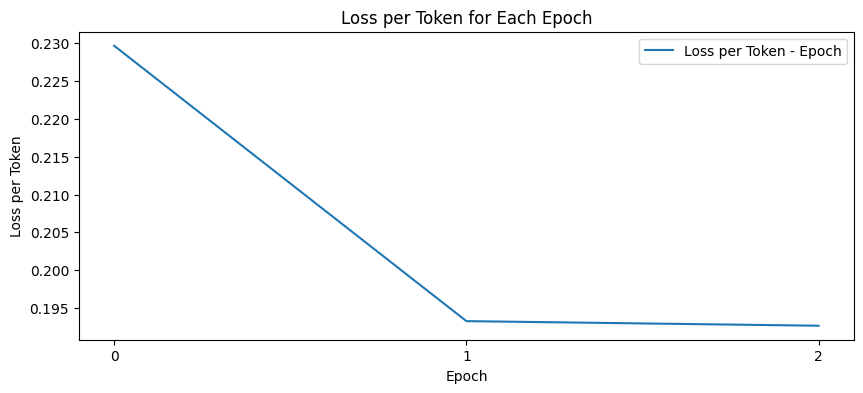

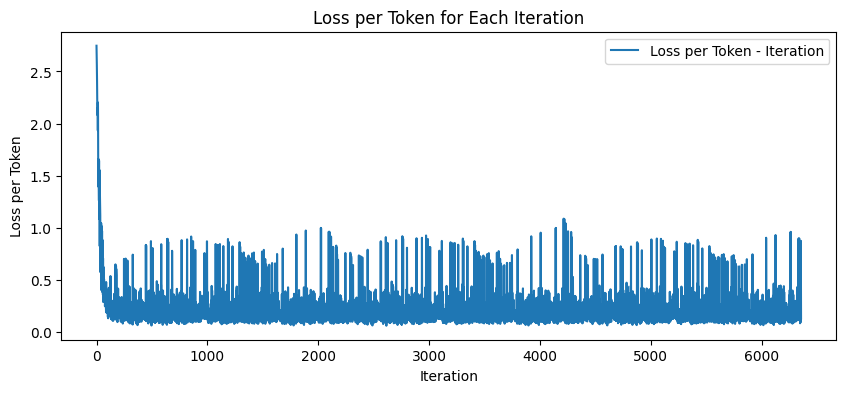

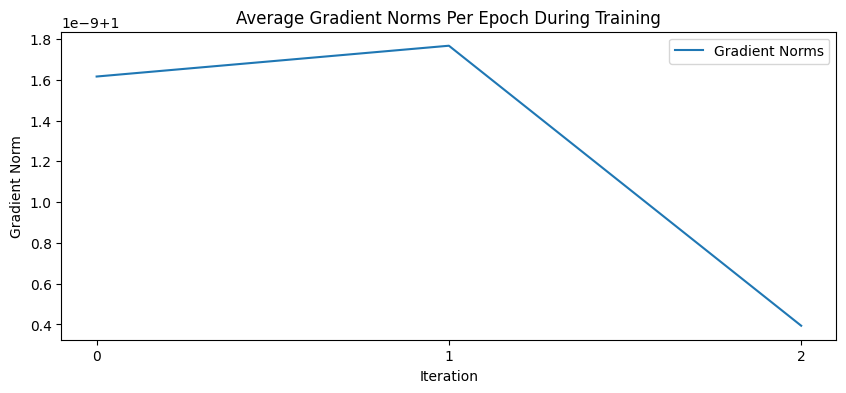

In [14]:
import matplotlib.pyplot as plt

# Plotting loss per token for each epoch
plt.figure(figsize=(10, 4))
plt.plot(loss_per_token_epoch, label='Loss per Token - Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss per Token')
plt.title('Loss per Token for Each Epoch')
plt.xticks(range(len(loss_per_token_epoch)))
plt.legend()
plt.show()

# Plotting loss per token for each iteration
plt.figure(figsize=(10, 4))
plt.plot(loss_per_token_iter, label='Loss per Token - Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss per Token')
plt.title('Loss per Token for Each Iteration')
plt.legend()
plt.show()


#plotting the gradient norms per epoch
plt.figure(figsize=(10, 4))
plt.plot(gradient_norms_list, label='Gradient Norms')
plt.xlabel('Iteration')
plt.ylabel('Gradient Norm')
plt.title('Average Gradient Norms Per Epoch During Training')
plt.xticks(range(len(loss_per_token_epoch)))
plt.legend()
plt.show()

# Brackets Dataset
---

In [12]:
x_train, (i2w, w2i) = load_brackets(n=150_000)

In [13]:
import time
from tqdm import tqdm


#assign the variables
vocab = len(w2i)
input_dim = len(w2i)
embed_size = 32
hidden_dim = 16
lstm_layers = 3
temp = 0.0
epochs = 50
lr = 0.0001
max_len = 50



model = LSTM(input_dim, embed_size, hidden_dim, vocab, lstm_layers)
model.to(device)



#we can use 'mean' for reduction with setting ignore_index. (Masking)
criterion = nn.CrossEntropyLoss(reduction = 'sum', ignore_index=w2i['.pad'])
optimizer = optim.Adam(model.parameters(),lr= lr)

#create the batches
max_tokens_per_batch = 1000
batches = create_batches(x_train, max_tokens_per_batch)

#store the loss per token for every iteration and every epoch
loss_per_token_epoch = []
loss_per_token_iter = []

#strat training
generated_samples_list = []
gradient_norms_list = []
for epoch in range(epochs):


    time1 = time.time()
    epoch_loss = 0
    gradient_norms = []
    for batch in tqdm(batches, desc=f'Epoch {epoch+1}/{epochs}'):
        input_tensor, target_tensor = process_batches(batch, w2i)
        #move input and target tensor to device
        input_tensor, target_tensor = move_to_device((input_tensor, target_tensor),device)
        #reset gradients
        optimizer.zero_grad()
        #set model to training mode
        model.train()
        #Forward pass
        output = model(input_tensor)
        '''
        print(f'output shape = {output.shape}')
        print(f'target shape = {target_tensor.shape}')
        '''
        #compute loss
        #we need to make output in the needed format as (batch_size,vocab_size,sequence_length)
        loss = criterion(output.transpose(1,2),target_tensor)
        #backward pass
        loss.backward()
        #gradient clipping to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        #loss per token
        # Calculate the number of non-padding tokens
        non_padding_tokens = (target_tensor != w2i['.pad']).sum()
        # Compute the gradient norm and store it
        total_norm = 0
        for p in model.parameters():
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
        gradient_norms.append(total_norm)
        #update weights
        optimizer.step()

        #calculate the total loss for epoch
        loss_per_iter = loss.item()/non_padding_tokens.item()
        loss_per_token_iter.append(loss_per_iter)

        #accumulate loss for epoch loss
        epoch_loss += loss_per_iter

    #calculate average loss per token for a single epoch
    loss_epoch = epoch_loss / len(batches)
    loss_per_token_epoch.append(loss_epoch)
    gradient_norms_list.append(np.mean(gradient_norms))
    time2 = time.time()
    print(f'Epoch {epoch + 1}, Loss: {epoch_loss / len(batches)}, Time: {time2-time1}')


    #Generate samples after each epoch
    generated_samples_single_epoch = []
    seed_seq = torch.tensor([w2i['.start'], w2i['('], w2i['('], w2i[')']]).unsqueeze(0)
    seed_seq = seed_seq.to(device)  # Move seed sequence to the device
    for i in range(10):
        #teperature is 0 for brackets dataset
        seq = generate_samples(model, seed_seq, max_len, temp, w2i)
        generated_samples_single_epoch.append([i2w[i.item()] for i in seq[0]])  # Convert indices to words
    #add the samples for single epoch to top list
    generated_samples_list.append(generated_samples_single_epoch)
torch.save(model.state_dict(), 'model_brackets.pth')

Epoch 1/50: 100%|██████████| 1402/1402 [00:51<00:00, 27.29it/s]


Epoch 1, Loss: 1.063445643314322, Time: 51.380581855773926


Epoch 2/50: 100%|██████████| 1402/1402 [00:51<00:00, 27.44it/s]


Epoch 2, Loss: 0.6235602112040944, Time: 51.105327129364014


Epoch 3/50: 100%|██████████| 1402/1402 [00:50<00:00, 28.02it/s]


Epoch 3, Loss: 0.5999906567880996, Time: 50.034560203552246


Epoch 4/50: 100%|██████████| 1402/1402 [00:48<00:00, 28.64it/s]


Epoch 4, Loss: 0.5912367996900519, Time: 48.950400590896606


Epoch 5/50: 100%|██████████| 1402/1402 [00:50<00:00, 27.79it/s]


Epoch 5, Loss: 0.5863745274106251, Time: 50.44677543640137


Epoch 6/50: 100%|██████████| 1402/1402 [00:49<00:00, 28.06it/s]


Epoch 6, Loss: 0.5832102666044915, Time: 49.97701978683472


Epoch 7/50: 100%|██████████| 1402/1402 [00:49<00:00, 28.25it/s]


Epoch 7, Loss: 0.5771308758246921, Time: 49.63213133811951


Epoch 8/50: 100%|██████████| 1402/1402 [00:50<00:00, 27.85it/s]


Epoch 8, Loss: 0.57330355226886, Time: 50.34990692138672


Epoch 9/50: 100%|██████████| 1402/1402 [00:49<00:00, 28.30it/s]


Epoch 9, Loss: 0.5678261917104563, Time: 49.551050662994385


Epoch 10/50: 100%|██████████| 1402/1402 [00:49<00:00, 28.23it/s]


Epoch 10, Loss: 0.5646973124343541, Time: 49.672536849975586


Epoch 11/50: 100%|██████████| 1402/1402 [00:49<00:00, 28.05it/s]


Epoch 11, Loss: 0.5628868437384621, Time: 49.98494839668274


Epoch 12/50: 100%|██████████| 1402/1402 [00:49<00:00, 28.55it/s]


Epoch 12, Loss: 0.5603745720663871, Time: 49.106043100357056


Epoch 13/50: 100%|██████████| 1402/1402 [00:51<00:00, 27.31it/s]


Epoch 13, Loss: 0.558963325024222, Time: 51.34363842010498


Epoch 14/50: 100%|██████████| 1402/1402 [00:50<00:00, 27.95it/s]


Epoch 14, Loss: 0.5577964692210414, Time: 50.159515619277954


Epoch 15/50: 100%|██████████| 1402/1402 [00:48<00:00, 28.84it/s]


Epoch 15, Loss: 0.5574691721035422, Time: 48.624656438827515


Epoch 16/50: 100%|██████████| 1402/1402 [00:50<00:00, 27.96it/s]


Epoch 16, Loss: 0.5560932328479745, Time: 50.144567251205444


Epoch 17/50: 100%|██████████| 1402/1402 [00:50<00:00, 27.91it/s]


Epoch 17, Loss: 0.5552359007369082, Time: 50.23794412612915


Epoch 18/50: 100%|██████████| 1402/1402 [00:48<00:00, 28.69it/s]


Epoch 18, Loss: 0.5550950418647698, Time: 48.87523412704468


Epoch 19/50: 100%|██████████| 1402/1402 [00:50<00:00, 27.96it/s]


Epoch 19, Loss: 0.5534342881649136, Time: 50.14340424537659


Epoch 20/50: 100%|██████████| 1402/1402 [00:48<00:00, 28.87it/s]


Epoch 20, Loss: 0.5530977017815294, Time: 48.56770062446594


Epoch 21/50: 100%|██████████| 1402/1402 [00:49<00:00, 28.21it/s]


Epoch 21, Loss: 0.5526716999523588, Time: 49.697001218795776


Epoch 22/50: 100%|██████████| 1402/1402 [00:50<00:00, 28.01it/s]


Epoch 22, Loss: 0.5521640543830278, Time: 50.04886269569397


Epoch 23/50: 100%|██████████| 1402/1402 [00:48<00:00, 28.92it/s]


Epoch 23, Loss: 0.5518069374072037, Time: 48.48094367980957


Epoch 24/50: 100%|██████████| 1402/1402 [00:49<00:00, 28.15it/s]


Epoch 24, Loss: 0.5515201315328994, Time: 49.80896043777466


Epoch 25/50: 100%|██████████| 1402/1402 [00:48<00:00, 28.68it/s]


Epoch 25, Loss: 0.5512398725688468, Time: 48.8885715007782


Epoch 26/50: 100%|██████████| 1402/1402 [00:49<00:00, 28.07it/s]


Epoch 26, Loss: 0.55108594821283, Time: 49.95130228996277


Epoch 27/50: 100%|██████████| 1402/1402 [00:50<00:00, 27.86it/s]


Epoch 27, Loss: 0.5510643695676252, Time: 50.33138394355774


Epoch 28/50: 100%|██████████| 1402/1402 [00:48<00:00, 28.67it/s]


Epoch 28, Loss: 0.5511288113912565, Time: 48.89675807952881


Epoch 29/50: 100%|██████████| 1402/1402 [00:50<00:00, 28.03it/s]


Epoch 29, Loss: 0.5512193278683404, Time: 50.02453303337097


Epoch 30/50: 100%|██████████| 1402/1402 [00:49<00:00, 28.08it/s]


Epoch 30, Loss: 0.5514507291485715, Time: 49.92484426498413


Epoch 31/50: 100%|██████████| 1402/1402 [00:48<00:00, 28.76it/s]


Epoch 31, Loss: 0.5516740335359913, Time: 48.74567723274231


Epoch 32/50: 100%|██████████| 1402/1402 [00:50<00:00, 27.94it/s]


Epoch 32, Loss: 0.5519114179130251, Time: 50.1834499835968


Epoch 33/50: 100%|██████████| 1402/1402 [00:48<00:00, 28.73it/s]


Epoch 33, Loss: 0.5520947582397976, Time: 48.80834150314331


Epoch 34/50: 100%|██████████| 1402/1402 [00:49<00:00, 28.08it/s]


Epoch 34, Loss: 0.5523240696048173, Time: 49.93750333786011


Epoch 35/50: 100%|██████████| 1402/1402 [00:50<00:00, 27.97it/s]


Epoch 35, Loss: 0.5524309481332298, Time: 50.137094497680664


Epoch 36/50: 100%|██████████| 1402/1402 [00:48<00:00, 28.92it/s]


Epoch 36, Loss: 0.5525389159380355, Time: 48.476287603378296


Epoch 37/50: 100%|██████████| 1402/1402 [00:50<00:00, 28.02it/s]


Epoch 37, Loss: 0.5525872390631137, Time: 50.04345178604126


Epoch 38/50: 100%|██████████| 1402/1402 [00:49<00:00, 28.20it/s]


Epoch 38, Loss: 0.552696304652299, Time: 49.730188608169556


Epoch 39/50: 100%|██████████| 1402/1402 [00:49<00:00, 28.60it/s]


Epoch 39, Loss: 0.5526740724662126, Time: 49.032912254333496


Epoch 40/50: 100%|██████████| 1402/1402 [00:50<00:00, 27.81it/s]


Epoch 40, Loss: 0.5526779100360247, Time: 50.42990255355835


Epoch 41/50: 100%|██████████| 1402/1402 [00:48<00:00, 28.63it/s]


Epoch 41, Loss: 0.5525631423115918, Time: 48.97368836402893


Epoch 42/50: 100%|██████████| 1402/1402 [00:50<00:00, 27.89it/s]


Epoch 42, Loss: 0.5519644458839892, Time: 50.2832727432251


Epoch 43/50: 100%|██████████| 1402/1402 [00:50<00:00, 28.01it/s]


Epoch 43, Loss: 0.5527535135881438, Time: 50.05332350730896


Epoch 44/50: 100%|██████████| 1402/1402 [00:48<00:00, 28.65it/s]


Epoch 44, Loss: 0.5526916224783338, Time: 48.94547438621521


Epoch 45/50: 100%|██████████| 1402/1402 [00:50<00:00, 27.89it/s]


Epoch 45, Loss: 0.5542203735712682, Time: 50.28234887123108


Epoch 46/50: 100%|██████████| 1402/1402 [00:49<00:00, 28.05it/s]


Epoch 46, Loss: 0.5547884315611245, Time: 49.988953828811646


Epoch 47/50: 100%|██████████| 1402/1402 [00:49<00:00, 28.49it/s]


Epoch 47, Loss: 0.5547657976604837, Time: 49.216418743133545


Epoch 48/50: 100%|██████████| 1402/1402 [00:49<00:00, 28.16it/s]


Epoch 48, Loss: 0.556535093954479, Time: 49.78985333442688


Epoch 49/50: 100%|██████████| 1402/1402 [00:48<00:00, 28.62it/s]


Epoch 49, Loss: 0.5548287749646972, Time: 48.98953914642334


Epoch 50/50: 100%|██████████| 1402/1402 [00:50<00:00, 27.88it/s]


Epoch 50, Loss: 0.5548258282509542, Time: 50.299349784851074


In [14]:
[w2i['.start'], w2i['('], w2i['('], w2i[')']]

[1, 5, 5, 4]

In [15]:
i = 1
start_seq = [[w2i['.start'], w2i['('], w2i['('], w2i[')']]]
print(f'start sequence: {start_seq}')
for single_epoch in generated_samples_list:
    print(f'EPOCH {i}:')
    for x in single_epoch:
      print(x)
    print()
    i +=1


start sequence: [[1, 5, 5, 4]]
EPOCH 1:
['.start', '(', '(', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')']
['.start', '(', '(', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')']
['.start', '(', '(', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')']
['.start', '(', '(', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', '

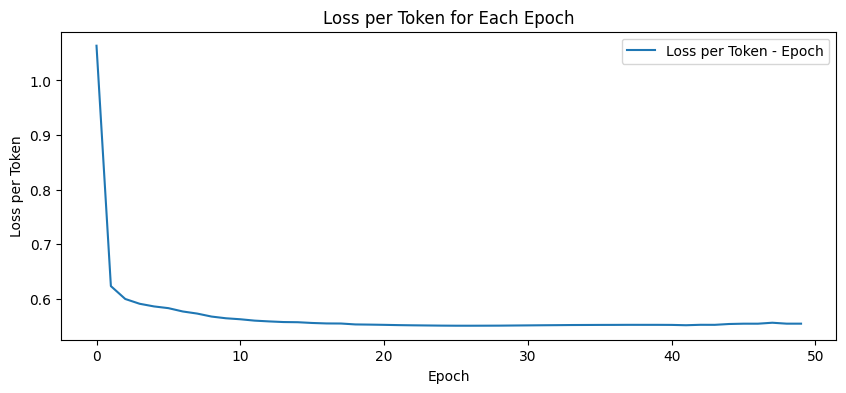

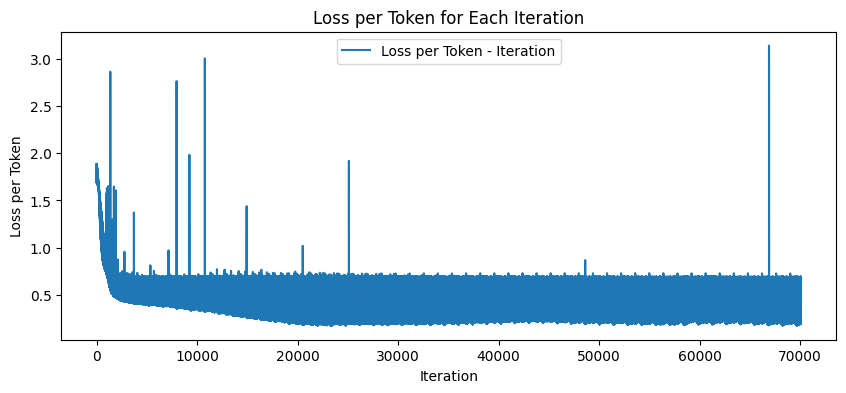

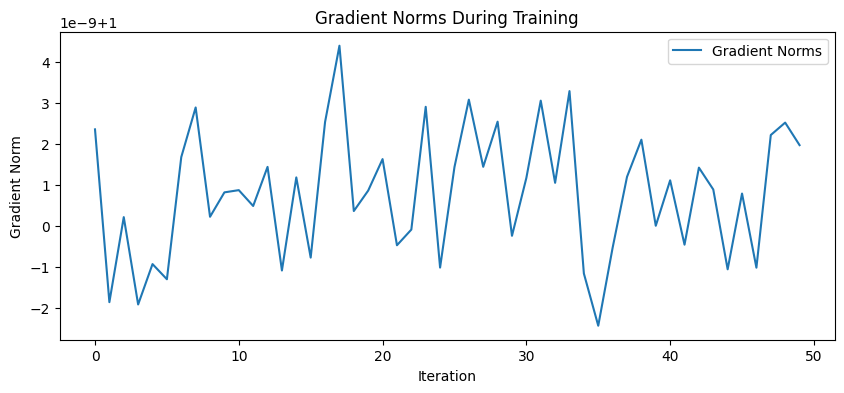

In [16]:
import matplotlib.pyplot as plt

# Plotting loss per token for each epoch
plt.figure(figsize=(10, 4))
plt.plot(loss_per_token_epoch, label='Loss per Token - Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss per Token')
plt.title('Loss per Token for Each Epoch')

plt.legend()
plt.show()

# Plotting loss per token for each iteration
plt.figure(figsize=(10, 4))
plt.plot(loss_per_token_iter, label='Loss per Token - Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss per Token')
plt.title('Loss per Token for Each Iteration')
plt.legend()
plt.show()

#plotting the gradient norms per epoch
plt.figure(figsize=(10, 4))
plt.plot(gradient_norms_list , label='Gradient Norms')#bunu degisitr
plt.xlabel('Iteration')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norms During Training')
plt.legend()
plt.show()